In [1]:
# Bryce Testing

In [2]:
import pandas as pd 
import numpy as np 
from os import listdir as ls
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import warnings
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.metrics import confusion_matrix

In [3]:
v1 = pd.read_parquet('[2015, 2016]_game_stats.parquet.gzip')
v2 = pd.read_parquet('[2017, 2018]_game_stats.parquet.gzip')
v3 = pd.read_parquet('[2019, 2020]_game_stats.parquet.gzip')
v4 = pd.read_parquet('[2021, 2022]_game_stats.parquet.gzip')
season_reg = pd.concat([v1, v2, v3, v4], axis = 0)
teams = season_reg['home_team'].unique()
arenas = season_reg['arena'].unique()

In [4]:
class OneHotEncoder:
    def __init__(self, categories):
        self.categories = categories
        self.category_to_index = {category: i for i, category in enumerate(categories)}
        self.num_categories = len(categories)

    def encode(self, category):
        if category not in self.category_to_index:
            raise ValueError(f"Category '{category}' not found in the provided categories.")
        else:
            encoded_vector = np.zeros(self.num_categories, dtype=np.float32)
            encoded_vector[self.category_to_index[category]] = 1
            return encoded_vector
team_encoder = OneHotEncoder(teams)
arena_encoder = OneHotEncoder(arenas)

In [5]:
#create a dictionary with season team and per list 
seasons_pers = pd.read_csv('seasons_per_s.csv')

def get_top_n_pers(seasons_pers, n): # can adjust to get pers of past seasonm on the new seasons roster
    roster_pers = {}
    for season in seasons_pers['season'].unique():
        subset = seasons_pers[seasons_pers['season'] == season]
        roster_pers[season] = {}
        for team in teams:
            team_subset = subset[subset['team_id'] ==  team]
            team_subset = team_subset.sort_values(by='per', ascending=False)
            roster_pers[season][team] = np.float32(team_subset['per'].iloc[:n]).flatten()
    return roster_pers

rosters = get_top_n_pers(seasons_pers, 10)  # rosters[season][team]

In [6]:
# pipeline 
def get_season(season_string):
    cleaned_reg_season = season_reg.copy()
    columns = season_reg.columns
    date_features = ['date']
    string_features = [ 'home_team', 'away_team', 'arena']
    numeric_features = [ c for c in columns if c not in string_features + date_features]
    cleaned_reg_season[numeric_features] = cleaned_reg_season[numeric_features].apply(pd.to_numeric)
    cleaned_reg_season[date_features] = cleaned_reg_season[date_features].apply(pd.to_datetime)
    start_date, end_date = f'20{season_string[2:4]}-10',  f'20{season_string[-2:]}-04'
    season = cleaned_reg_season[(cleaned_reg_season["date"] >= start_date) & (cleaned_reg_season["date"] <= end_date)]
    return season

def run_pca(season= '2019-20'):
    season = get_season(season)
    pca = PCA(n_components=30)
    season_numeric = season.drop(["date", "home_team", "away_team", "arena"] , axis=1)
    numeric_components = pca.fit(season_numeric)
    return pca 

def pre_process(season, pca, data_all):
    season_name = season
    season = get_season(season)
    #drop cloumns to perform pca 
    season_numeric = season.drop(["date", "home_team", "away_team", "arena"] , axis=1)
    season_categorical = season[["date", "home_team", "away_team", "arena"]]
    numeric_components = np.array(pca.transform(season_numeric), dtype=np.float32)
    spread = np.float32(season_numeric["home_pts"] - season_numeric["away_pts"])
    if data_all == True:
        # one hot encoded teams
        home_team = []
        away_team = []
        arena = []
        home_pers = []
        away_pers = []
        for index, row in season_categorical.iterrows():
            # print(row[1], row[2], row[3])
            home_team.append(team_encoder.encode(row.iloc[1]))
            away_team.append(team_encoder.encode(row.iloc[2]))
            arena.append(arena_encoder.encode(row.iloc[3]))
            # get top n player pers
            top_n = 10
            if season_name == '2014-15':
                raise Exception('cannot train on games in 2014-15 season, start with the 2015-16 season instead')
            else: 
                start = int(season_name[0:4])-1
                end = int(season_name[-2:])-1
                prior_season_name = f'{start}-{end}'
            home_pers.append(rosters[prior_season_name][row.iloc[1]])
            away_pers.append(rosters[prior_season_name][row.iloc[2]])

        
        return {'home_per_input': tf.convert_to_tensor(home_pers[:-1]),
       'home_team_input': tf.convert_to_tensor(home_team[:-1]),
       'season_pca_input': tf.convert_to_tensor(numeric_components[:-1]),
       'arena_input': tf.convert_to_tensor(arena[:-1]),
       'away_team_input': tf.convert_to_tensor(away_team[:-1]),
       'away_per_input': tf.convert_to_tensor(away_pers[:-1])}, tf.convert_to_tensor(spread[1:])
    else:
        return numeric_components[:-1], spread[1:]

In [ ]:
def get_team_avgs(season_name):
    season_name = season
    start = int(season_name[0:4])-1
    end = int(season_name[-2:])-1
    prior_season_name = f'{start}-{end}'
    season = get_season(prior_season_name)
    # GET TEAM AVG FOR THE WHOLE PAST SEASON 

    #GET ROLLING AVG FOR TEAMS USING EACH GAME OF CURRENT SEASON 

    
    
    

In [7]:
pca = run_pca('2015-16')

# x_2020, y_2020= pre_process('2019-20', pca, data_all=False)
# x_2021, y_2021= pre_process('2020-21', pca, data_all=False)

x_2016, y_2016= pre_process('2015-16', pca, data_all=True)
x_2017, y_2017= pre_process('2016-17', pca, data_all=True)

In [8]:
# regression model 
games = [1, 2, 3, 4, 5, 6] #games remove last game 
scores = [1 ,2, 3, 4, 5, 6] #scores remove 1st score 
games[:-1]
scores[1:]

[2, 3, 4, 5, 6]

In [9]:
# Define input layers for each input
home_per_input = tf.keras.Input(shape=(10,), name='home_per_input')
home_team_input = tf.keras.Input(shape=(30,), name='home_team_input')
season_pca_input = tf.keras.Input(shape=(30,), name='season_pca_input')
arena_input = tf.keras.Input(shape=(51,), name='arena_input')
away_team_input = tf.keras.Input(shape=(30,), name='away_team_input')
away_per_input = tf.keras.Input(shape=(10,), name='away_per_input')

# Concatenate or merge the inputs
concatenated_inputs = tf.keras.layers.concatenate([home_per_input, home_team_input, season_pca_input, arena_input, away_team_input, away_per_input])

# Define the rest of your model architecture
h1 = tf.keras.layers.Dense(161, activation="relu")(concatenated_inputs)
h2 = tf.keras.layers.Dense(200, activation="relu")(h1)
h3 = tf.keras.layers.Dense(200, activation="relu")(h2)
h4 = tf.keras.layers.Dense(25, activation="relu")(h3)
h5 = tf.keras.layers.Dense(25, activation="relu")(h4)
output = tf.keras.layers.Dense(1, activation="linear")(h5)

# Create the model
bigger_model = tf.keras.Model(inputs=[home_per_input, home_team_input, season_pca_input, arena_input, away_team_input, away_per_input], outputs=output)

# Compile the model
bigger_model.compile(loss='mean_squared_error', optimizer="adam", metrics=["accuracy", "mean_squared_error"])

# Print the model summary
bigger_model.summary()
tf.keras.backend.clear_session()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ home_per_input      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_team_input     │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ season_pca_input    │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ arena_input         │ (None, 51)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_team_input     │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_per_input      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 161)       │          0 │ home_per_input[0… │
│ (Concatenate)       │                   │            │ home_team_input[… │
│                     │                   │            │ season_pca_input… │
│                     │                   │            │ arena_input[0][0… │
│                     │                   │            │ away_team_input[… │
│                     │                   │            │ away_per_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 161)       │     26,082 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 200)       │     32,400 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 200)       │     40,200 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 25)        │      5,025 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 25)        │        650 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         26 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 104,383 (407.75 KB)

 Trainable params: 104,383 (407.75 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = bigger_model.fit(x=x_2016,
    y=y_2016, epochs=10, validation_split = 0.3)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0120 - loss: 173.8153 - mean_squared_error: 173.7785 - val_accuracy: 0.0147 - val_loss: 187.4312 - val_mean_squared_error: 186.0925
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0107 - loss: 184.5337 - mean_squared_error: 184.5672 - val_accuracy: 0.0147 - val_loss: 185.8771 - val_mean_squared_error: 184.7861
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0156 - loss: 162.8688 - mean_squared_error: 162.8515 - val_accuracy: 0.0029 - val_loss: 187.3215 - val_mean_squared_error: 186.0401
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0073 - loss: 179.2447 - mean_squared_error: 179.2570 - val_accuracy: 0.0147 - val_loss: 184.9137 - val_mean_squared_error: 183.7120
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0109 - loss: 168.4280 - mean_squared_error: 168.4335 - val_accuracy: 0.0147 - val_loss: 186.0727 - val_mean_squared_error: 185.2607
Epoch 6/10
25/25 ━━━

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


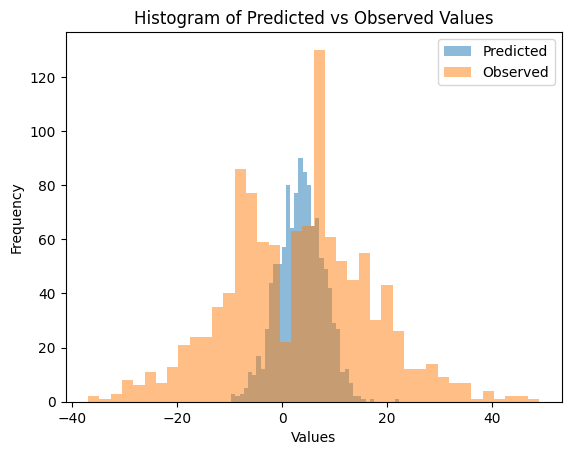

In [11]:
import matplotlib.pyplot as plt

predictions = pd.DataFrame(bigger_model.predict(x_2017).flatten())

predicted_values = predictions
observed_values = y_2017


# Plot histogram
plt.hist(predicted_values, bins=40, label='Predicted', alpha=0.5)
plt.hist(observed_values, bins=40, label='Observed', alpha=0.5)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted vs Observed Values')
plt.legend()
plt.show()

In [12]:
# classification - moneyline 
def get_moneyline(y_data):
    y_ml = pd.DataFrame(y_data.numpy())
    outcomes = []
    for index, row in y_ml.iterrows(): 
        if row[0] > 0: #win
            outcomes.append(np.float32([1, 0]))
        else:
            outcomes.append(np.float32([0, 1]))
    return tf.convert_to_tensor(outcomes)

In [13]:
# Define input layers for each input
home_per_input = tf.keras.Input(shape=(10,), name='home_per_input')
home_team_input = tf.keras.Input(shape=(30,), name='home_team_input')
season_pca_input = tf.keras.Input(shape=(30,), name='season_pca_input')
arena_input = tf.keras.Input(shape=(51,), name='arena_input')
away_team_input = tf.keras.Input(shape=(30,), name='away_team_input')
away_per_input = tf.keras.Input(shape=(10,), name='away_per_input')

# Concatenate or merge the inputs
concatenated_inputs = tf.keras.layers.concatenate([home_per_input, home_team_input, season_pca_input, arena_input, away_team_input, away_per_input])

# Define the rest of your model architecture
h1 = tf.keras.layers.Dense(161, activation="relu")(concatenated_inputs)
h2 = tf.keras.layers.Dense(150, activation="relu")(h1)
h3 = tf.keras.layers.Dense(150, activation="relu")(h2)
h4 = tf.keras.layers.Dense(100, activation="relu")(h3)
h5 = tf.keras.layers.Dense(25, activation="relu")(h4)
output = tf.keras.layers.Dense(2, activation="softmax")(h5)

# Create the model
bigger_model_c = tf.keras.Model(inputs=[home_per_input, home_team_input, season_pca_input, arena_input, away_team_input, away_per_input], outputs=output)

# Compile the model
bigger_model_c.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])

# Print the model summary
# bigger_model_c.summary()
tf.keras.backend.clear_session()

In [14]:
history = bigger_model_c.fit(x=x_2016,
    y=get_moneyline(y_2016), epochs=10, validation_split = 0.3)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5369 - loss: 0.7376 - val_accuracy: 0.5836 - val_loss: 0.7025
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5891 - loss: 0.6755 - val_accuracy: 0.5806 - val_loss: 0.6909
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6062 - loss: 0.6595 - val_accuracy: 0.5924 - val_loss: 0.6791
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6103 - loss: 0.6527 - val_accuracy: 0.5572 - val_loss: 0.6873
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6262 - loss: 0.6511 - val_accuracy: 0.6070 - val_loss: 0.6833
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6268 - loss: 0.6416 - val_accuracy: 0.5484 - val_loss: 0.7020
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6498 - loss: 0.6250 - val_accuracy: 0.5953 - val_loss: 0.7332
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6551 - loss: 0.5951 - val_accuracy: 0.5630 - val_loss:

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


(array([669.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 467.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

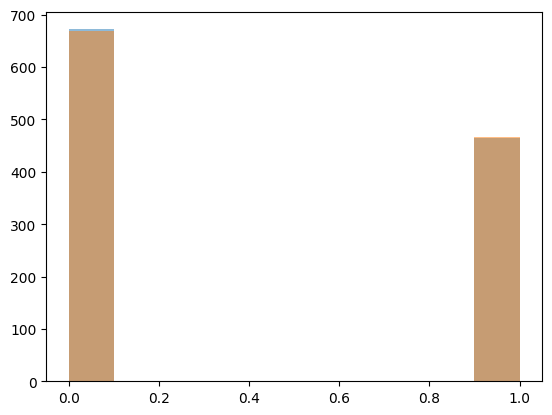

In [15]:
predictions = pd.DataFrame(bigger_model_c.predict(x_2016))
predictions = np.argmax(predictions.to_numpy(), axis = 1)
plt.hist(predictions, alpha=0.5, label='preds')
observed = np.argmax(get_moneyline(y_2016).numpy(),  axis =1)
plt.hist(observed, alpha=0.5, label='obser')

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step


(array([664.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 475.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

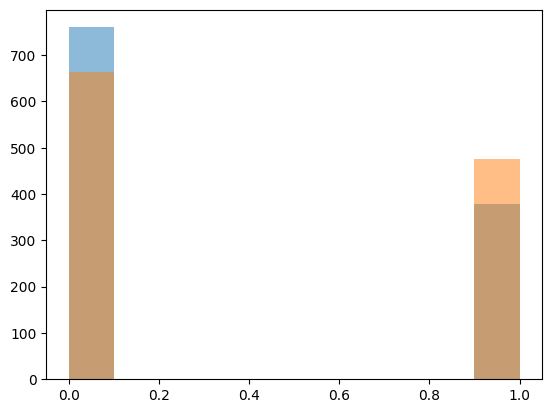

In [16]:
predictions = pd.DataFrame(bigger_model_c.predict(x_2017))
predictions = np.argmax(predictions.to_numpy(), axis = 1)
plt.hist(predictions, alpha=0.5, label='preds')
observed = np.argmax(get_moneyline(y_2017).numpy(),  axis =1)
plt.hist(observed, alpha=0.5, label='obser')

In [17]:
# trying moneyline oh team preds 
def pre_process_oh(season, pca, data_all):
    season_name = season
    season = get_season(season)
    # shuffles data
    season  = season.sample(frac=1).reset_index(drop=True)
    alt_season = season.copy(deep=True)
    #drop cloumns to perform pca 
    season_numeric = season.drop(["date", "home_team", "away_team", "arena"] , axis=1)
    season_categorical = season[["date", "home_team", "away_team", "arena"]]
    numeric_components = np.array(pca.transform(season_numeric), dtype=np.float32)
    spread = np.float32(season_numeric["home_pts"] - season_numeric["away_pts"])
    alt_season['spread'] = spread
    alt_season['result'] = np.where(alt_season['spread'] > 0, alt_season['home_team'], alt_season['away_team'])
    alt_season = alt_season[["home_team", "away_team", "arena", "result"]]
    if data_all == True:
        # one hot encoded teams
        home_team = []
        away_team = []
        arena = []
        home_pers = []
        away_pers = []
        winner = []
        for index, row in alt_season.iterrows():
            home_team.append(team_encoder.encode(row.iloc[0]))
            away_team.append(team_encoder.encode(row.iloc[1]))
            arena.append(arena_encoder.encode(row.iloc[2]))
            winner.append(team_encoder.encode(row.iloc[3]))
            # get top n player pers
            top_n = 10
            if season_name == '2014-15':
                raise Exception('cannot train on games in 2014-15 season, start with the 2015-16 season instead')
            else: 
                start = int(season_name[0:4])-1
                end = int(season_name[-2:])-1
                prior_season_name = f'{start}-{end}'
            home_pers.append(rosters[prior_season_name][row.iloc[0]])
            away_pers.append(rosters[prior_season_name][row.iloc[1]])

        
        return {'home_per_input': tf.convert_to_tensor(home_pers[:-1]),
       'home_team_input': tf.convert_to_tensor(home_team[:-1]),
       'season_pca_input': tf.convert_to_tensor(numeric_components[:-1]),
       'arena_input': tf.convert_to_tensor(arena[:-1]),
       'away_team_input': tf.convert_to_tensor(away_team[:-1]),
       'away_per_input': tf.convert_to_tensor(away_pers[:-1])},  tf.convert_to_tensor(winner[1:])
    else:
        return numeric_components[:-1], spread[1:]

In [18]:
x_2016, y_2016= pre_process_oh('2015-16', pca, data_all=True)
x_2017, y_2017= pre_process_oh('2016-17', pca, data_all=True)

In [19]:
# Define input layers for each input
home_per_input = tf.keras.Input(shape=(10,), name='home_per_input')
home_team_input = tf.keras.Input(shape=(30,), name='home_team_input')
season_pca_input = tf.keras.Input(shape=(30,), name='season_pca_input')
arena_input = tf.keras.Input(shape=(51,), name='arena_input')
away_team_input = tf.keras.Input(shape=(30,), name='away_team_input')
away_per_input = tf.keras.Input(shape=(10,), name='away_per_input')

# Concatenate or merge the inputs
concatenated_inputs = tf.keras.layers.concatenate([home_per_input, home_team_input, season_pca_input, arena_input, away_team_input, away_per_input])

# Define the rest of your model architecture
h1 = tf.keras.layers.Dense(161, activation="relu")(concatenated_inputs)
h2 = tf.keras.layers.Dense(200, activation="relu")(h1)
h3 = tf.keras.layers.Dense(200, activation="relu")(h2)
h4 = tf.keras.layers.Dense(25, activation="relu")(h3)
h5 = tf.keras.layers.Dense(25, activation="relu")(h4)
concatenated_teams = tf.keras.layers.concatenate([home_team_input, h5, away_team_input])
output = tf.keras.layers.Dense(30, activation="softmax")(concatenated_teams )

# Create the model
bigger_model_m_oh = tf.keras.Model(inputs=[home_per_input, home_team_input, season_pca_input, arena_input, away_team_input, away_per_input], outputs=output)

# Compile the model
bigger_model_m_oh.compile(loss=categorical_crossentropy, optimizer="adam", metrics=["accuracy"])

# Print the model summary
bigger_model_m_oh.summary()
tf.keras.backend.clear_session()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ home_team_input     │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_per_input      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ season_pca_input    │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ arena_input         │ (None, 51)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_team_input     │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_per_input      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 161)       │          0 │ home_per_input[0… │
│ (Concatenate)       │                   │            │ home_team_input[… │
│                     │                   │            │ season_pca_input… │
│                     │                   │            │ arena_input[0][0… │
│                     │                   │            │ away_team_input[… │
│                     │                   │            │ away_per_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 161)       │     26,082 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 200)       │     32,400 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 200)       │     40,200 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 25)        │      5,025 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 25)        │        650 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 85)        │          0 │ home_team_input[… │
│ (Concatenate)       │                   │            │ dense_4[0][0],    │
│                     │                   │            │ away_team_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 30)        │      2,580 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 106,937 (417.72 KB)

 Trainable params: 106,937 (417.72 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = bigger_model_m_oh.fit(x=x_2016,
    y=y_2016, epochs=10, validation_split = 0.3)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0597 - loss: 3.4297 - val_accuracy: 0.0411 - val_loss: 3.4163
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0565 - loss: 3.3740 - val_accuracy: 0.0381 - val_loss: 3.4093
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0560 - loss: 3.3609 - val_accuracy: 0.0323 - val_loss: 3.4034
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0641 - loss: 3.3153 - val_accuracy: 0.0381 - val_loss: 3.3983
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0766 - loss: 3.2786 - val_accuracy: 0.0293 - val_loss: 3.4038
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0847 - loss: 3.2801 - val_accuracy: 0.0381 - val_loss: 3.3933
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0948 - loss: 3.2432 - val_accuracy: 0.0411 - val_loss: 3.3904
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0685 - loss: 3.2242 - val_accuracy: 0.0352 - val_loss:

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


(array([106., 103., 114., 118., 122., 128., 122.,  87., 115., 124.]),
 array([ 0. ,  2.9,  5.8,  8.7, 11.6, 14.5, 17.4, 20.3, 23.2, 26.1, 29. ]),
 <BarContainer object of 10 artists>)

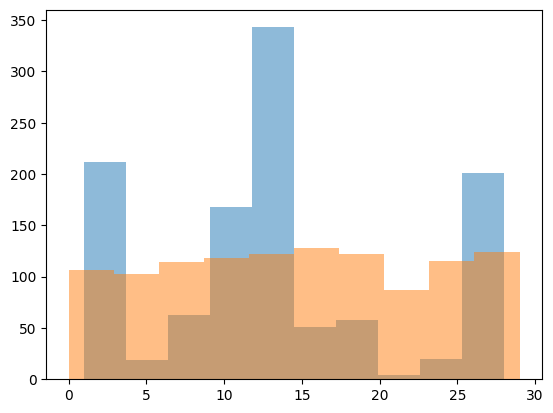

In [21]:
predictions = pd.DataFrame(bigger_model_m_oh.predict(x_2017))
predictions = np.argmax(predictions.to_numpy(), axis = 1)
plt.hist(predictions, alpha=0.5, label='preds')
observed = np.argmax(y_2017.numpy(),  axis =1)
plt.hist(observed, alpha=0.5, label='obser')

In [22]:
#shuffling training data to see how it affects results

In [23]:
x_2016, y_2016= pre_process_oh('2015-16', pca, data_all=True)
x_2017, y_2017= pre_process_oh('2016-17', pca, data_all=True)

In [24]:
history = bigger_model_m_oh.fit(x=x_2016,
    y=y_2016, epochs=10, validation_split = 0.3)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0387 - loss: 3.4039 - val_accuracy: 0.0645 - val_loss: 3.3640
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0427 - loss: 3.3790 - val_accuracy: 0.0616 - val_loss: 3.3645
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0444 - loss: 3.3583 - val_accuracy: 0.0587 - val_loss: 3.3848
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0636 - loss: 3.2982 - val_accuracy: 0.0645 - val_loss: 3.3787
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0537 - loss: 3.2664 - val_accuracy: 0.0674 - val_loss: 3.3860
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0602 - loss: 3.2670 - val_accuracy: 0.0587 - val_loss: 3.3885
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0913 - loss: 3.2486 - val_accuracy: 0.0645 - val_loss: 3.4264
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0807 - loss: 3.1995 - val_accuracy: 0.0645 - val_loss:

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


(array([106., 103., 114., 118., 122., 128., 122.,  87., 115., 124.]),
 array([ 0. ,  2.9,  5.8,  8.7, 11.6, 14.5, 17.4, 20.3, 23.2, 26.1, 29. ]),
 <BarContainer object of 10 artists>)

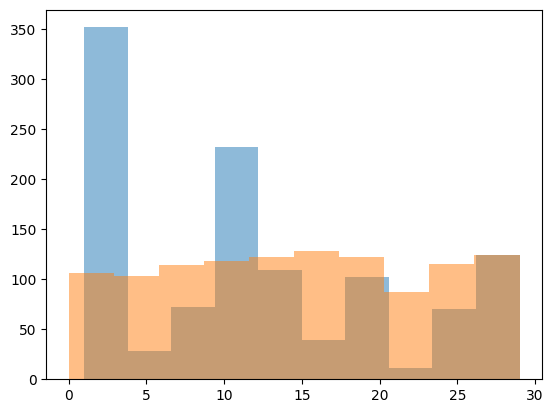

In [25]:
predictions = pd.DataFrame(bigger_model_m_oh.predict(x_2017))
predictions = np.argmax(predictions.to_numpy(), axis = 1)
plt.hist(predictions, alpha=0.5, label='preds')
observed = np.argmax(y_2017.numpy(),  axis =1)
plt.hist(observed, alpha=0.5, label='obser')

In [26]:
# Define input layers for each input
home_per_input = tf.keras.Input(shape=(10,), name='home_per_input')
home_team_input = tf.keras.Input(shape=(30,), name='home_team_input')
season_pca_input = tf.keras.Input(shape=(30,), name='season_pca_input')
arena_input = tf.keras.Input(shape=(51,), name='arena_input')
away_team_input = tf.keras.Input(shape=(30,), name='away_team_input')
away_per_input = tf.keras.Input(shape=(10,), name='away_per_input')

# Concatenate or merge the inputs
concatenated_inputs = tf.keras.layers.concatenate([home_per_input, home_team_input, season_pca_input, arena_input, away_team_input, away_per_input])

# Define the rest of your model architecture
h1 = tf.keras.layers.Dense(161, activation="relu")(concatenated_inputs)
h2 = tf.keras.layers.Dense(200, activation="relu")(h1)
h3 = tf.keras.layers.Dense(200, activation="relu")(h2)
h4 = tf.keras.layers.Dense(25, activation="relu")(h3)
h5 = tf.keras.layers.Dense(25, activation="relu")(h4)
concatenated_teams = tf.keras.layers.concatenate([home_team_input, h5, away_team_input])
output_spread = tf.keras.layers.Dense(1, activation="linear", name = 'spread')(h5)
output_outcome = tf.keras.layers.Dense(30, activation="softmax", name = 'outcome')(concatenated_teams)
# Create the model
bigger_model_do = tf.keras.Model(inputs=[home_per_input, home_team_input, season_pca_input, arena_input, away_team_input, away_per_input], outputs=[output_spread, output_outcome])

# Compile the model
bigger_model_do.compile(loss={'spread':'mean_squared_error' , 'outcome':categorical_crossentropy}, optimizer="adam", metrics=["mean_squared_error", "accuracy"])

# Print the model summary
bigger_model_do.summary()
tf.keras.backend.clear_session()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ home_per_input      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_team_input     │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ season_pca_input    │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ arena_input         │ (None, 51)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_team_input     │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_per_input      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 161)       │          0 │ home_per_input[0… │
│ (Concatenate)       │                   │            │ home_team_input[… │
│                     │                   │            │ season_pca_input… │
│                     │                   │            │ arena_input[0][0… │
│                     │                   │            │ away_team_input[… │
│                     │                   │            │ away_per_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 161)       │     26,082 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 200)       │     32,400 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 200)       │     40,200 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 25)        │      5,025 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 25)        │        650 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 85)        │          0 │ home_team_input[… │
│ (Concatenate)       │                   │            │ dense_4[0][0],    │
│                     │                   │            │ away_team_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spread (Dense)      │ (None, 1)         │         26 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outcome (Dense)     │ (None, 30)        │      2,580 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 106,963 (417.82 KB)

 Trainable params: 106,963 (417.82 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
#start here for aws

In [28]:
# multi output model
def pre_process_mo(season, pca, data_all, n):
    season_name = season
    season = get_season(season)
    # shuffles data
    season  = season.sample(frac=1).reset_index(drop=True)
    alt_season = season.copy(deep=True)
    #drop cloumns to perform pca 
    season_numeric = season.drop(["date", "home_team", "away_team", "arena"] , axis=1)
    season_categorical = season[["date", "home_team", "away_team", "arena"]]
    numeric_components = np.array(pca.transform(season_numeric), dtype=np.float32)
    spread = np.float32(season_numeric["home_pts"] - season_numeric["away_pts"])
    alt_season['spread'] = spread
    alt_season['result'] = np.where(alt_season['spread'] > 0, alt_season['home_team'], alt_season['away_team'])
    alt_season = alt_season[["home_team", "away_team", "arena", "result"]]
    if data_all == True:
        # one hot encoded teams
        home_team = []
        away_team = []
        arena = []
        home_pers = []
        away_pers = []
        winner = []
        for index, row in alt_season.iterrows():
            home_team.append(team_encoder.encode(row.iloc[0]))
            away_team.append(team_encoder.encode(row.iloc[1]))
            arena.append(arena_encoder.encode(row.iloc[2]))
            winner.append(team_encoder.encode(row.iloc[3]))
            # get top n player pers
            top_n = n
            if season_name == '2014-15':
                raise Exception('cannot train on games in 2014-15 season, start with the 2015-16 season instead')
            else: 
                start = int(season_name[0:4])-1
                end = int(season_name[-2:])-1
                prior_season_name = f'{start}-{end}'
            home_pers.append(rosters[prior_season_name][row.iloc[0]])
            away_pers.append(rosters[prior_season_name][row.iloc[1]])
        
        return {'home_per_input': tf.convert_to_tensor(home_pers[:-1]),
       'home_team_input': tf.convert_to_tensor(home_team[:-1]),
       'season_pca_input': tf.convert_to_tensor(numeric_components[:-1]),
       'arena_input': tf.convert_to_tensor(arena[:-1]),
       'away_team_input': tf.convert_to_tensor(away_team[:-1]),
       'away_per_input': tf.convert_to_tensor(away_pers[:-1])},  {'spread': spread[1:], 'outcome': tf.convert_to_tensor(winner[1:])}
    else:
        return numeric_components[:-1], spread[1:]

In [29]:
x_2016, y_2016= pre_process_mo('2015-16', pca, data_all=True, n=10)
x_2017, y_2017= pre_process_mo('2016-17', pca, data_all=True, n=10)

np.save('2015-16_10.npy', {'x':x_2016, 'y':y_2016})
np.save('2016-17_10.npy', {'x':x_2017, 'y':y_2017})

In [30]:
history = bigger_model_do.fit(x=x_2016,
    y=y_2016, epochs=10, validation_split = 0.3)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 197.9647 - outcome_accuracy: 0.0621 - spread_mean_squared_error: 194.1151 - val_loss: 177.2711 - val_outcome_accuracy: 0.0381 - val_spread_mean_squared_error: 172.7848
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 195.0510 - outcome_accuracy: 0.0441 - spread_mean_squared_error: 191.2554 - val_loss: 178.5083 - val_outcome_accuracy: 0.0352 - val_spread_mean_squared_error: 174.2903
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 170.3305 - outcome_accuracy: 0.0599 - spread_mean_squared_error: 166.7629 - val_loss: 179.1409 - val_outcome_accuracy: 0.0352 - val_spread_mean_squared_error: 175.0956
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 191.4697 - outcome_accuracy: 0.0554 - spread_mean_squared_error: 187.9620 - val_loss: 177.2333 - val_outcome_accuracy: 0.0352 - val_spread_mean_squared_error: 173.0053
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 185.5027 - outcome_accuracy: 0.0617 - 

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


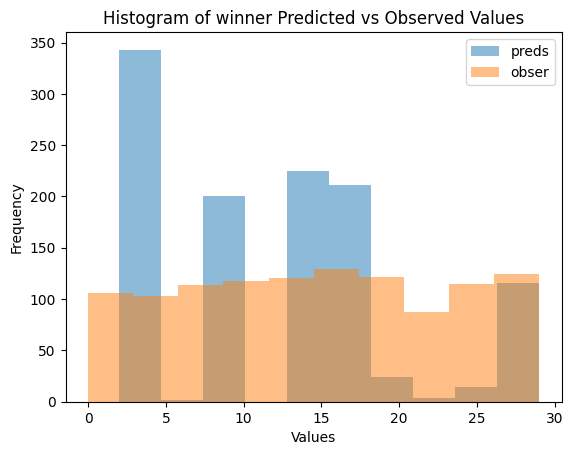

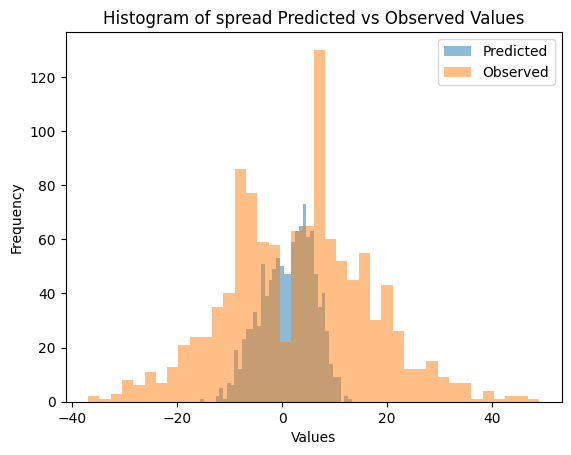

In [31]:
predictions = bigger_model_do.predict(x_2017)
pred_spred = predictions[0]
pred_outcome = predictions[1]

#outcome
predictions = np.argmax(pred_outcome, axis = 1)
plt.hist(predictions, alpha=0.5, label='preds')
observed = np.argmax(y_2017['outcome'],  axis =1)
plt.hist(observed, alpha=0.5, label='obser')
plt.legend()
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of winner Predicted vs Observed Values')
plt.show()


#spread 
plt.hist(pred_spred, bins=40, label='Predicted', alpha=0.5)
plt.hist(y_2017['spread'], bins=40, label='Observed', alpha=0.5)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of spread Predicted vs Observed Values')
plt.legend()
plt.show()


In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay




In [33]:
# Define input layers for each input
home_per_input = tf.keras.Input(shape=(10,), name='home_per_input')
home_team_input = tf.keras.Input(shape=(30,), name='home_team_input')
season_pca_input = tf.keras.Input(shape=(30,), name='season_pca_input')
arena_input = tf.keras.Input(shape=(51,), name='arena_input')
away_team_input = tf.keras.Input(shape=(30,), name='away_team_input')
away_per_input = tf.keras.Input(shape=(10,), name='away_per_input')

# Concatenate or merge the inputs
concatenated_inputs = tf.keras.layers.concatenate([home_per_input, home_team_input, season_pca_input, arena_input, away_team_input, away_per_input])

# Define the rest of your model architecture
h1 = tf.keras.layers.Dense(161, activation="relu")(concatenated_inputs)
h2 = tf.keras.layers.Dense(200, activation="relu")(h1)
h3 = tf.keras.layers.Dense(200, activation="relu")(h2)
h4 = tf.keras.layers.Dense(25, activation="relu")(h3)
h5 = tf.keras.layers.Dense(25, activation="relu")(h4)
concatenated_teams = tf.keras.layers.concatenate([home_team_input, h5, away_team_input])
output_spread = tf.keras.layers.Dense(1, activation="linear", name = 'spread')(h5)
output_outcome = tf.keras.layers.Dense(30, activation="softmax", name = 'outcome')(concatenated_teams)
# Create the model
bigger_model_do = tf.keras.Model(inputs=[home_per_input, home_team_input, season_pca_input, arena_input, away_team_input, away_per_input], outputs=[output_spread, output_outcome])

# Compile the model
bigger_model_do.compile(loss={'spread':'mean_squared_error' , 'outcome':categorical_crossentropy}, optimizer=tf.keras.optimizers.Nadam(), metrics=["mean_squared_error", "accuracy"])

# Print the model summary
bigger_model_do.summary()
tf.keras.backend.clear_session()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ home_per_input      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_team_input     │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ season_pca_input    │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ arena_input         │ (None, 51)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_team_input     │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_per_input      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 161)       │          0 │ home_per_input[0… │
│ (Concatenate)       │                   │            │ home_team_input[… │
│                     │                   │            │ season_pca_input… │
│                     │                   │            │ arena_input[0][0… │
│                     │                   │            │ away_team_input[… │
│                     │                   │            │ away_per_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 161)       │     26,082 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 200)       │     32,400 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 200)       │     40,200 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 25)        │      5,025 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 25)        │        650 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 85)        │          0 │ home_team_input[… │
│ (Concatenate)       │                   │            │ dense_4[0][0],    │
│                     │                   │            │ away_team_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spread (Dense)      │ (None, 1)         │         26 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outcome (Dense)     │ (None, 30)        │      2,580 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 106,963 (417.82 KB)

 Trainable params: 106,963 (417.82 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
history = bigger_model_do.fit(x=x_2016,
    y=y_2016, epochs=10, validation_split = 0.3)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 194.2361 - outcome_accuracy: 0.0659 - spread_mean_squared_error: 190.5487 - val_loss: 176.1351 - val_outcome_accuracy: 0.0381 - val_spread_mean_squared_error: 171.9626
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 182.7332 - outcome_accuracy: 0.0544 - spread_mean_squared_error: 179.1114 - val_loss: 180.0720 - val_outcome_accuracy: 0.0469 - val_spread_mean_squared_error: 176.0212
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 176.0990 - outcome_accuracy: 0.0432 - spread_mean_squared_error: 172.6035 - val_loss: 177.5862 - val_outcome_accuracy: 0.0381 - val_spread_mean_squared_error: 173.5115
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 173.7425 - outcome_accuracy: 0.0604 - spread_mean_squared_error: 170.2698 - val_loss: 177.2972 - val_outcome_accuracy: 0.0499 - val_spread_mean_squared_error: 173.0387
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 169.6135 - outcome_accuracy: 0.0692 - 

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


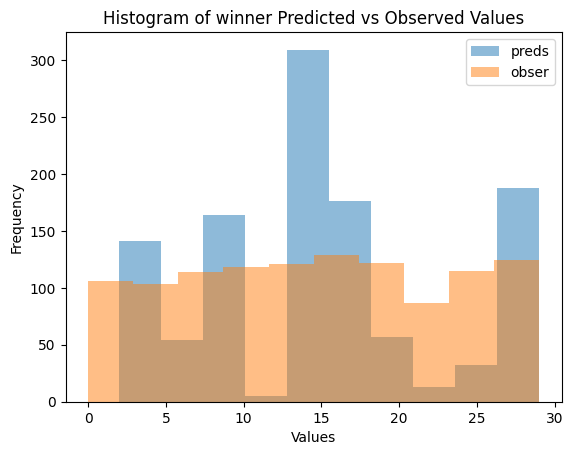

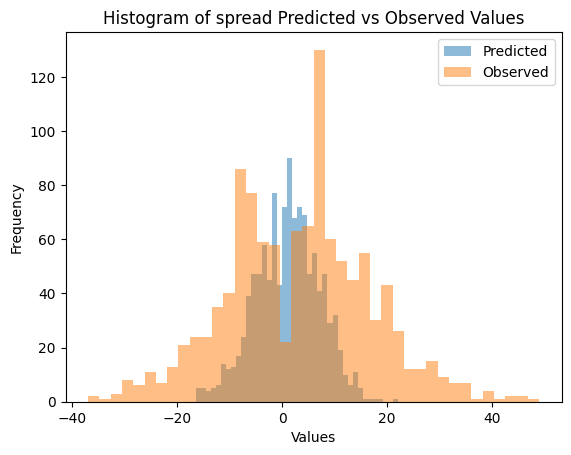

In [35]:
predictions = bigger_model_do.predict(x_2017)
pred_spred = predictions[0]
pred_outcome = predictions[1]

#outcome
predictions = np.argmax(pred_outcome, axis = 1)
plt.hist(predictions, alpha=0.5, label='preds')
observed = np.argmax(y_2017['outcome'],  axis =1)
plt.hist(observed, alpha=0.5, label='obser')
plt.legend()
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of winner Predicted vs Observed Values')
plt.show()


#spread 
plt.hist(pred_spred, bins=40, label='Predicted', alpha=0.5)
plt.hist(y_2017['spread'], bins=40, label='Observed', alpha=0.5)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of spread Predicted vs Observed Values')
plt.legend()
plt.show()

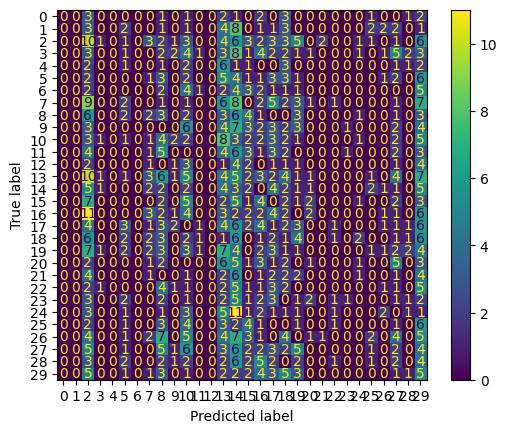

(array([106., 103., 114., 118., 121., 129., 122.,  87., 115., 124.]),
 array([ 0. ,  2.9,  5.8,  8.7, 11.6, 14.5, 17.4, 20.3, 23.2, 26.1, 29. ]),
 <BarContainer object of 10 artists>)

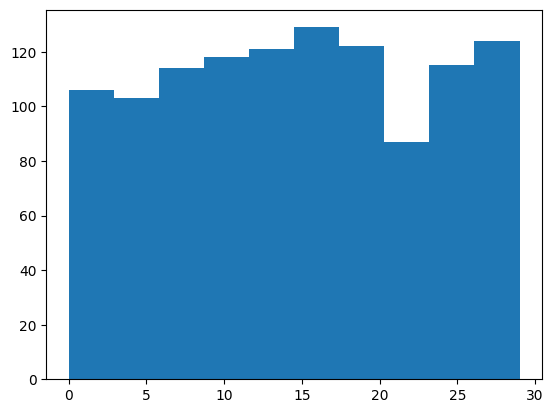

In [36]:
cm = ConfusionMatrixDisplay(confusion_matrix(observed, predictions))
cm.plot()
plt.show()

plt.hist(observed)

# april 13th 

In [39]:
# Define input layers for each input
# home_per_input = tf.keras.Input(shape=(10,), name='home_per_input')
home_team_input = tf.keras.Input(shape=(30,), name='home_team_input')
# season_pca_input = tf.keras.Input(shape=(30,), name='season_pca_input')
arena_input = tf.keras.Input(shape=(51,), name='arena_input')
away_team_input = tf.keras.Input(shape=(30,), name='away_team_input')
# away_per_input = tf.keras.Input(shape=(10,), name='away_per_input')

# Concatenate or merge the inputs
concatenated_inputs = tf.keras.layers.concatenate([home_team_input, arena_input, away_team_input])

# Define the rest of your model architecture
h1 = tf.keras.layers.Dense(161, activation="leaky_relu")(concatenated_inputs)
h2 = tf.keras.layers.Dense(200, activation="leaky_relu")(h1)
h3 = tf.keras.layers.Dense(200, activation="leaky_relu")(h2)
h4 = tf.keras.layers.Dense(25, activation="leaky_relu")(h3)
h5 = tf.keras.layers.Dense(25, activation="leaky_relu")(h4)
concatenated_teams = tf.keras.layers.concatenate([home_team_input, h5, away_team_input])
output_spread = tf.keras.layers.Dense(1, activation="linear", name = 'spread')(h5)
output_outcome = tf.keras.layers.Dense(30, activation="softmax", name = 'outcome')(concatenated_teams)
# Create the model
bigger_model_do = tf.keras.Model(inputs=[home_team_input, arena_input, away_team_input], outputs=[output_spread, output_outcome])

# Compile the model
bigger_model_do.compile(loss={'spread':'mean_squared_error' , 'outcome':categorical_crossentropy}, optimizer=tf.keras.optimizers.Nadam(), metrics=["mean_squared_error", "accuracy"])

# Print the model summary
bigger_model_do.summary()
tf.keras.backend.clear_session()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ home_team_input     │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ arena_input         │ (None, 51)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_team_input     │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 111)       │          0 │ home_team_input[… │
│ (Concatenate)       │                   │            │ arena_input[0][0… │
│                     │                   │            │ away_team_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 161)       │     18,032 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 200)       │     32,400 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 200)       │     40,200 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 25)        │      5,025 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 25)        │        650 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 85)        │          0 │ home_team_input[… │
│ (Concatenate)       │                   │            │ dense_4[0][0],    │
│                     │                   │            │ away_team_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spread (Dense)      │ (None, 1)         │         26 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outcome (Dense)     │ (None, 30)        │      2,580 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 98,913 (386.38 KB)

 Trainable params: 98,913 (386.38 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# multi output model
def pre_process_base(season, pca, data_all, n):
    season_name = season
    season = get_season(season)
    # shuffles data
    season  = season.sample(frac=1).reset_index(drop=True)
    alt_season = season.copy(deep=True)
    #drop cloumns to perform pca 
    season_numeric = season.drop(["date", "home_team", "away_team", "arena"] , axis=1)
    season_categorical = season[["date", "home_team", "away_team", "arena"]]
    numeric_components = np.array(pca.transform(season_numeric), dtype=np.float32)
    spread = np.float32(season_numeric["home_pts"] - season_numeric["away_pts"])
    alt_season['spread'] = spread
    alt_season['result'] = np.where(alt_season['spread'] > 0, alt_season['home_team'], alt_season['away_team'])
    alt_season = alt_season[["home_team", "away_team", "arena", "result"]]
    if data_all == True:
        # one hot encoded teams
        home_team = []
        away_team = []
        arena = []
        home_pers = []
        away_pers = []
        winner = []
        for index, row in alt_season.iterrows():
            home_team.append(team_encoder.encode(row.iloc[0]))
            away_team.append(team_encoder.encode(row.iloc[1]))
            arena.append(arena_encoder.encode(row.iloc[2]))
            winner.append(team_encoder.encode(row.iloc[3]))
            # get top n player pers
            top_n = n
            if season_name == '2014-15':
                raise Exception('cannot train on games in 2014-15 season, start with the 2015-16 season instead')
            else: 
                start = int(season_name[0:4])-1
                end = int(season_name[-2:])-1
                prior_season_name = f'{start}-{end}'
            home_pers.append(rosters[prior_season_name][row.iloc[0]])
            away_pers.append(rosters[prior_season_name][row.iloc[1]])
        
        return {
       'home_team_input': tf.convert_to_tensor(home_team),
       # 'season_pca_input': tf.convert_to_tensor(numeric_components[:-1]),
       'arena_input': tf.convert_to_tensor(arena),
       'away_team_input': tf.convert_to_tensor(away_team),
       },  {'spread': spread, 'outcome': tf.convert_to_tensor(winner)}
    else:
        return numeric_components, spread

In [40]:
x_2016, y_2016= pre_process_base('2015-16', pca, data_all=True, n=10)
x_2017, y_2017= pre_process_base('2016-17', pca, data_all=True, n=10)
history = bigger_model_do.fit(x=x_2016,
    y=y_2016, epochs=10, validation_split = 0.3)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 186.0321 - outcome_accuracy: 0.0374 - spread_mean_squared_error: 182.6275 - val_loss: 166.3488 - val_outcome_accuracy: 0.0556 - val_spread_mean_squared_error: 160.2233
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 158.9179 - outcome_accuracy: 0.0450 - spread_mean_squared_error: 155.5541 - val_loss: 149.3181 - val_outcome_accuracy: 0.0702 - val_spread_mean_squared_error: 143.2738
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 136.7254 - outcome_accuracy: 0.0754 - spread_mean_squared_error: 133.4147 - val_loss: 145.9865 - val_outcome_accuracy: 0.0877 - val_spread_mean_squared_error: 139.9640
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 134.8924 - outcome_accuracy: 0.0853 - spread_mean_squared_error: 131.6231 - val_loss: 147.6997 - val_outcome_accuracy: 0.1023 - val_spread_mean_squared_error: 141.5852
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 124.8565 - outcome_accuracy: 0.1222 - 

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


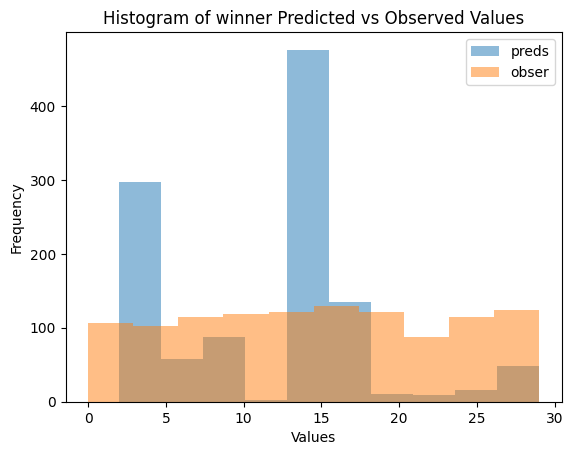

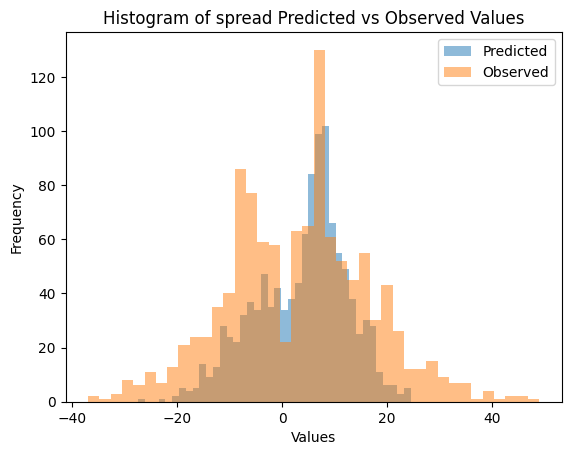

In [41]:
predictions = bigger_model_do.predict(x_2017)
pred_spred = predictions[0]
pred_outcome = predictions[1]

#outcome
predictions = np.argmax(pred_outcome, axis = 1)
plt.hist(predictions, alpha=0.5, label='preds')
observed = np.argmax(y_2017['outcome'],  axis =1)
plt.hist(observed, alpha=0.5, label='obser')
plt.legend()
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of winner Predicted vs Observed Values')
plt.show()


#spread 
plt.hist(pred_spred, bins=40, label='Predicted', alpha=0.5)
plt.hist(y_2017['spread'], bins=40, label='Observed', alpha=0.5)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of spread Predicted vs Observed Values')
plt.legend()
plt.show()

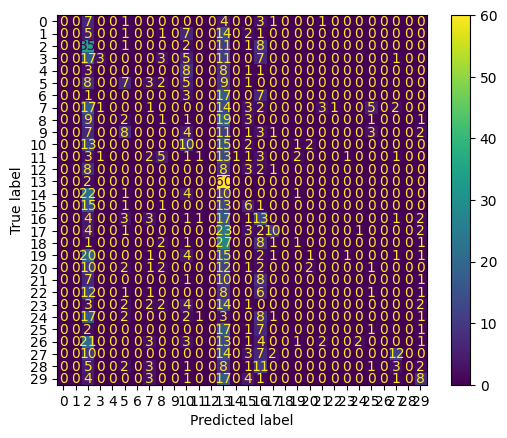

(array([106., 103., 114., 118., 122., 129., 122.,  87., 115., 124.]),
 array([ 0. ,  2.9,  5.8,  8.7, 11.6, 14.5, 17.4, 20.3, 23.2, 26.1, 29. ]),
 <BarContainer object of 10 artists>)

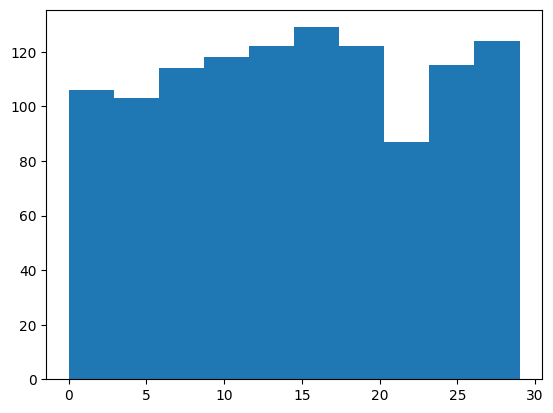

In [42]:
cm = ConfusionMatrixDisplay(confusion_matrix(observed, predictions))
cm.plot()
plt.show()

plt.hist(observed)

In [43]:
# base with pers 

In [102]:
# Define input layers for each input
home_per_input = tf.keras.Input(shape=(10,), name='home_per_input')
home_team_input = tf.keras.Input(shape=(30,), name='home_team_input')
# season_pca_input = tf.keras.Input(shape=(30,), name='season_pca_input')
arena_input = tf.keras.Input(shape=(51,), name='arena_input')
away_team_input = tf.keras.Input(shape=(30,), name='away_team_input')
away_per_input = tf.keras.Input(shape=(10,), name='away_per_input')

# Concatenate or merge the inputs
concatenated_inputs = tf.keras.layers.concatenate([home_per_input, home_team_input, arena_input, away_team_input, away_per_input])
activeFunc = 'gelu'
# Define the rest of your model architecture
h1 = tf.keras.layers.Dense(161, activation=activeFunc)(concatenated_inputs)
h2 = tf.keras.layers.Dense(200, activation=activeFunc)(h1)
h3 = tf.keras.layers.Dense(200, activation=activeFunc)(h2)
h4 = tf.keras.layers.Dense(25, activation=activeFunc)(h3)
h5 = tf.keras.layers.Dense(25, activation=activeFunc)(h4)
concatenated_teams = tf.keras.layers.concatenate([home_team_input, h5, away_team_input])
output_spread = tf.keras.layers.Dense(1, activation="linear", name = 'spread')(h5)
output_outcome = tf.keras.layers.Dense(30, activation="softmax", name = 'outcome')(concatenated_teams)
# Create the model
bigger_model_bp = tf.keras.Model(inputs=[home_per_input, home_team_input, arena_input, away_team_input, away_per_input], outputs=[output_spread, output_outcome])

# Compile the model
bigger_model_bp.compile(loss={'spread':'mean_squared_error' , 'outcome':categorical_crossentropy}, optimizer=tf.keras.optimizers.Nadam(), metrics=["mean_squared_error", "accuracy"])

# Print the model summary
bigger_model_bp.summary()
tf.keras.backend.clear_session()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ home_per_input      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_team_input     │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ arena_input         │ (None, 51)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_team_input     │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_per_input      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 131)       │          0 │ home_per_input[0… │
│ (Concatenate)       │                   │            │ home_team_input[… │
│                     │                   │            │ arena_input[0][0… │
│                     │                   │            │ away_team_input[… │
│                     │                   │            │ away_per_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 161)       │     21,252 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 200)       │     32,400 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 200)       │     40,200 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 25)        │      5,025 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 25)        │        650 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 85)        │          0 │ home_team_input[… │
│ (Concatenate)       │                   │            │ dense_4[0][0],    │
│                     │                   │            │ away_team_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spread (Dense)      │ (None, 1)         │         26 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outcome (Dense)     │ (None, 30)        │      2,580 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 102,133 (398.96 KB)

 Trainable params: 102,133 (398.96 KB)

 Non-trainable params: 0 (0.00 B)

In [103]:
# multi output model
def pre_process_base(season, pca, data_all, n):
    season_name = season
    season = get_season(season)
    # shuffles data
    season  = season.sample(frac=1).reset_index(drop=True)
    alt_season = season.copy(deep=True)
    #drop cloumns to perform pca 
    season_numeric = season.drop(["date", "home_team", "away_team", "arena"] , axis=1)
    season_categorical = season[["date", "home_team", "away_team", "arena"]]
    numeric_components = np.array(pca.transform(season_numeric), dtype=np.float32)
    spread = np.float32(season_numeric["home_pts"] - season_numeric["away_pts"])
    alt_season['spread'] = spread
    alt_season['result'] = np.where(alt_season['spread'] > 0, alt_season['home_team'], alt_season['away_team'])
    alt_season = alt_season[["home_team", "away_team", "arena", "result"]]
    if data_all == True:
        # one hot encoded teams
        home_team = []
        away_team = []
        arena = []
        home_pers = []
        away_pers = []
        winner = []
        for index, row in alt_season.iterrows():
            home_team.append(team_encoder.encode(row.iloc[0]))
            away_team.append(team_encoder.encode(row.iloc[1]))
            arena.append(arena_encoder.encode(row.iloc[2]))
            winner.append(team_encoder.encode(row.iloc[3]))
            # get top n player pers
            top_n = n
            if season_name == '2014-15':
                raise Exception('cannot train on games in 2014-15 season, start with the 2015-16 season instead')
            else: 
                start = int(season_name[0:4])-1
                end = int(season_name[-2:])-1
                prior_season_name = f'{start}-{end}'
            home_pers.append(rosters[prior_season_name][row.iloc[0]])
            away_pers.append(rosters[prior_season_name][row.iloc[1]])
        
        return {'home_per_input': tf.convert_to_tensor(home_pers),
       'home_team_input': tf.convert_to_tensor(home_team),
       # 'season_pca_input': tf.convert_to_tensor(numeric_components[:-1]),
       'arena_input': tf.convert_to_tensor(arena),
       'away_team_input': tf.convert_to_tensor(away_team),
       'away_per_input': tf.convert_to_tensor(away_pers)},  {'spread': spread, 'outcome': tf.convert_to_tensor(winner)}
    else:
        return numeric_components, spread

In [104]:
x_2016, y_2016= pre_process_base('2015-16', pca, data_all=True, n=10)
x_2017, y_2017= pre_process_base('2016-17', pca, data_all=True, n=10)
history = bigger_model_bp.fit(x=x_2016,
    y=y_2016, epochs=20, validation_split = 0.3)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 193.1829 - outcome_accuracy: 0.0242 - spread_mean_squared_error: 189.6160 - val_loss: 167.3361 - val_outcome_accuracy: 0.0292 - val_spread_mean_squared_error: 162.7557
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 189.9471 - outcome_accuracy: 0.0503 - spread_mean_squared_error: 186.5218 - val_loss: 167.0769 - val_outcome_accuracy: 0.0292 - val_spread_mean_squared_error: 162.5452
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 192.2410 - outcome_accuracy: 0.0472 - spread_mean_squared_error: 188.8654 - val_loss: 167.2356 - val_outcome_accuracy: 0.0380 - val_spread_mean_squared_error: 162.6781
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 188.2153 - outcome_accuracy: 0.0356 - spread_mean_squared_error: 184.7529 - val_loss: 165.7314 - val_outcome_accuracy: 0.0760 - val_spread_mean_squared_error: 161.2697
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 177.5124 - outcome_accuracy: 0.0964 - 

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step


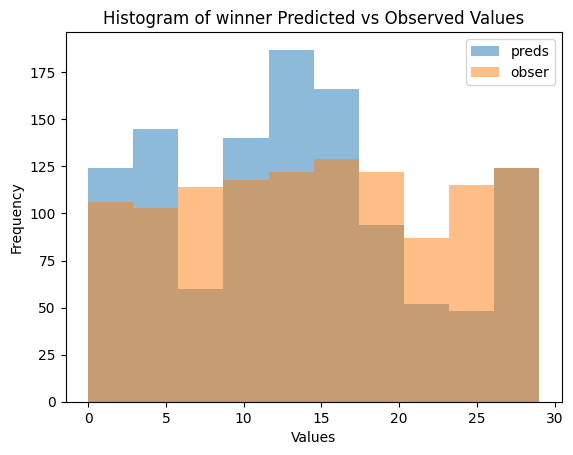

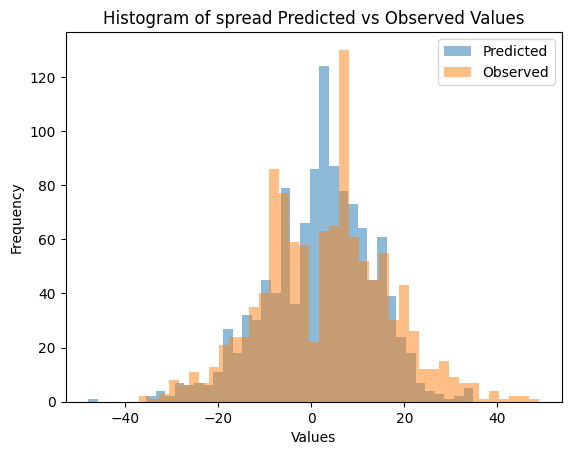

In [95]:
predictions = bigger_model_do.predict(x_2017)
pred_spred = predictions[0]
pred_outcome = predictions[1]

#outcome
predictions = np.argmax(pred_outcome, axis = 1)
plt.hist(predictions, alpha=0.5, label='preds')
observed = np.argmax(y_2017['outcome'],  axis =1)
plt.hist(observed, alpha=0.5, label='obser')
plt.legend()
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of winner Predicted vs Observed Values')
plt.show()


#spread 
plt.hist(pred_spred, bins=40, label='Predicted', alpha=0.5)
plt.hist(y_2017['spread'], bins=40, label='Observed', alpha=0.5)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of spread Predicted vs Observed Values')
plt.legend()
plt.show()



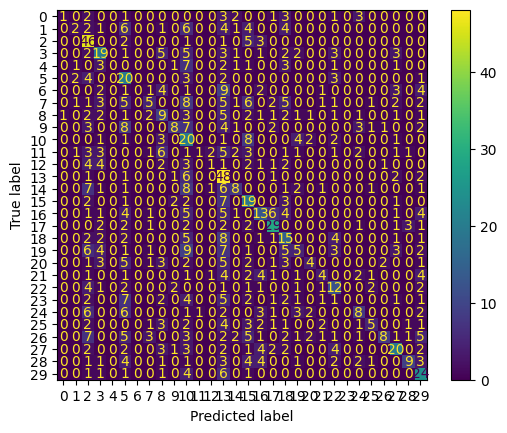

(array([106., 103., 114., 118., 122., 129., 122.,  87., 115., 124.]),
 array([ 0. ,  2.9,  5.8,  8.7, 11.6, 14.5, 17.4, 20.3, 23.2, 26.1, 29. ]),
 <BarContainer object of 10 artists>)

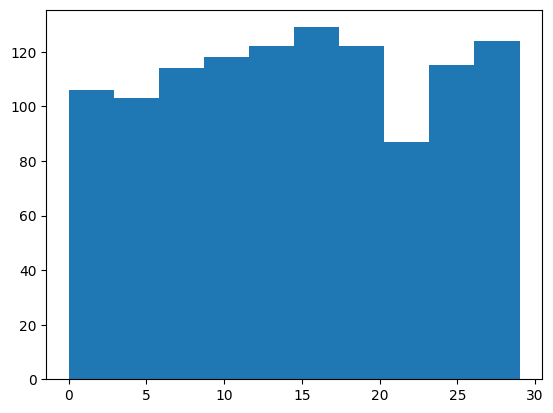

In [97]:
cm = ConfusionMatrixDisplay(confusion_matrix(observed, predictions))
cm.plot()
plt.show()

plt.hist(observed)

In [ ]:
relu, leaky relu, silu, mish, gelu 

In [ ]:
# 

    